## **Index**
-     <a href='#1'>1 Introduction</a>
    - <a href='#1.1'>      1.1 Problem Statement</a>
    - <a href='#1.2'>      1.2 Data </a>
-     <a href='#2'>2 Methodology</a>
    - <a href='#2.1'>  2.1 Exploratory Data Analysis </a>
        - <a href='#2.1.1'>          2.1.1 Descriptive Analysis </a>
           - <a href='#2.1.1.1'>            2.1.1.1 Features Analysis </a>
           - <a href='#2.1.1.2'>            2.1.1.2 Missing Value Analysis </a>
        - <a href='#2.1.2'>          2.1.2 Visualization </a>
           - <a href='#2.1.2.1'>            2.1.2.1 Target Variable: Count plot / Pie Chart </a>
           - <a href='#2.1.2.2'>            2.1.2.2 Outlier Analysis </a>
           - <a href='#2.1.2.3'>            2.1.2.3 Attributes Distributions and trends </a>
           - <a href='#2.1.2.4'>            2.1.2.4 Correlation Analysis / Heatmap </a>
    - <a href='#2.2'>      2.2 Data Preprocessing and Analysis </a>
        - <a href='#2.2.1'>          2.2.1 Outlier Handling </a>
        - <a href='#2.2.2'>          2.2.2 Principal component analysis (PCA) </a>
        - <a href='#2.2.3'>          2.2.3 Feature Selection </a>
        - <a href='#2.2.4'>          2.2.4 Feature Engineering </a>
    - <a href='#2.3'>      2.3 Modeling </a>
        - <a href='#2.3.1'>          2.3.1 Classifiation Models( KFold without scaling)</a>
        - <a href='#2.3.2'>          2.3.2 SMOTE models </a>
        - <a href='#2.3.3'>          2.3.3 LightGBM </a>
- <a href='#3'>3 Conclusion</a>

# <a id='1'>1. Introduction</a>

At Santander, mission is to help people and businesses prosper. We are always looking
for ways to help our customers understand their financial health and identify which
products and services might help them achieve their monetary goals.
Our data science team is continually challenging our machine learning algorithms,
working with the global data science community to make sure we can more accurately
identify new ways to solve our most common challenge, binary classification problems
such as: is a customer satisfied? Will a customer buy this product? Can a customer pay
this loan?



The aim of this notebook is to understand the process of EDA and Data-preparation, selection of features, implementing machine learning tools. Later, will comparing and improving the best models.

### <a id='1.1'>1.1 Problem Statement</a>
In this challenge, we need to identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted

### Objective
Since the labels in the data are discrete, the predication falls only into two categories. In machine learning, this is called classification problem.

> Hence our goal is to solve a binary classification problem. In the data description you can see that the features given are numeric and anonymized.

### Evaluation
For Classification the Accuracy metrics need to be considered are AUC, Precision & Recall. Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

### <a id='1.2'>1.2 About Dataset</a>
We are provided with an anonymized dataset containing numeric feature variables, the binary target column, and a string ID_code column.

The task is to predict the value of target column in the test set.

Dataset:
train.csv - the training set.
test.csv - the test set. The test set contains some rows which are not included in scoring.

The Train dataset contains 200000 observations of 202 columns.

1. The first two columns in the dataset store the unique ID_code numbers of the obseravtions and the corresponding "target" transaction prediction ,respectively.
2. The columns 2-202 contain 200 real-value features that have been captured which can be used to build a model to predict weather a transaction done by customer.

The Test dataset contains 200000 observations of 201 columns.

1. The first column in the dataset store the unique ID_code numbers of the obseravtions and the corresponding variables columns.
2. The columns 1-201 contain 200 real-value features that have been captured which will be used to test our model prediction on weather a transaction done by customer.



<b>Getting Started: Load libraries and dataset

In [1]:
# system
import os
import warnings

# data manipulation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import gc

# setting warning to ignored
warnings.filterwarnings("ignore")
print(os.listdir("../input"))

# importing classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# preprocessing/ cross-validation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

# evaluation metrics
from sklearn.metrics import make_scorer, roc_auc_score, auc, precision_score, recall_score, classification_report, roc_curve, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve

# pipeline builder
from sklearn.pipeline import Pipeline

# decompostion 
from sklearn.decomposition import PCA

# ensemble models
import lightgbm as lgb

# over sampling model
from imblearn.over_sampling import SMOTE

['test.csv', 'train.csv']


Using TensorFlow backend.


In [2]:
# loading the data files
train = pd.read_csv('../input/train.csv', sep=',')
test = pd.read_csv('../input/test.csv', sep=',')

<b>Inspecting Dataset</b>

The “info()” method provides a concise summary of the data; from the output, it provides the type of data in each column, the number of non-null values in each column, and how much memory the data frame is using.

In [3]:

# taking sneak peak to datasets
print(f'Dimension of our Train data {train.shape} \n Data feature informations')
print(train.info())
print(f'Dimension of our Test data {test.shape} \n Data feature informations')
print(test.info())

print(train.head(), test.head())
print(f'Train columns: {train.columns}\nTest columns: {test.columns}')

Dimension of our Train data (200000, 202) 
 Data feature informations
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB
None
Dimension of our Test data (200000, 201) 
 Data feature informations
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB
None
   ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

    

#### Observation:
1. Here, we have second column <b>"target"</b>, which is our objective to assert. Also, we will drop the column <b>ID_code</b> since, its no use for us.
2. As can bee seen above, except for the target all other features are of type float64 . 
3. Our target is int64 type with onlt two values or we can say two classes i.e. catogorical variable, so, later we'will apply encoding method upon it and convert it to numeric.

# <a id='2'>2. Methodology</a>
# <a id='2.1'>2.1 Exploratory Data Analysis(EDA)</a>
In this section, we'll explore the attributes and data values. Familiarity with data will provide more insight knowledge for data pre-processing,  analysize how to use graphical and numerical techniques to begin uncovering the structure of your data.

## Objectives of Data Exploration
Exploratory data analysis (EDA) is a very important step which takes place after feature engineering and acquiring data and it should be done before any modeling. This is because it is very important for a data scientist to be able to understand the nature of the data without making assumptions. The results of data exploration can be extremely useful in grasping the structure of the data, the distribution of the values, and the presence of extreme values and interrelationships within the data set

> Purpose of EDA:
1. Summarize the statistics and visualization of data for better understanding.Crubing indication for tendencies of the data, its quality and to formulate assumptions and the hypothesis of our analysis.
2. To create overall picture of the data with basic statistical description and aspects, and identify 

Prospectives used to examine the data:
1. Descriptive statistics
2. Visualization

## <a id='2.1.1'>2.1.1 Descriptive statistics</a>

## <a id='2.1.1.1'>2.1.1.1 Feature Analysis</a>
It is a summary statistic that quantitatively describes or summarizes features of a collection of information, process of condensing key characteristics of the data set into simple numeric metrics. Some of the common metrics used are mean, standard deviation, and correlation.

In [4]:
### EDA for understanding datasets and getting clues for feature selections.


# Datatypes in dataset
print('Train target column datatype:',train.target.dtype)
print('Train var_0 column datatype:',train.var_0.dtype)


print('Train Describe:\n',train.describe(),'\nTest Describe:\n', test.describe())
print('Different values in target:\n',train.target.unique())


Train target column datatype: int64
Train var_0 column datatype: float64
Train Describe:
               target          var_0          var_1          var_2  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.100490      10.679914      -1.627622      10.715192   
std         0.300653       3.040051       4.050044       2.640894   
min         0.000000       0.408400     -15.043400       2.117100   
25%         0.000000       8.453850      -4.740025       8.722475   
50%         0.000000      10.524750      -1.608050      10.580000   
75%         0.000000      12.758200       1.358625      12.516700   
max         1.000000      20.315000      10.376800      19.353000   

               var_3          var_4          var_5          var_6  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        6.796529      11.078333      -5.065317       5.408949   
std         2.043319       1.623150       7.863267       0.866607   
min        -

#### Observation:
1. Here, we have second column <b>"target"</b>, which is our objective to assert. 
2. As can bee seen above, except for the target all other features are of type float64 . 
3. Our target is int64 type with onlt two values or we can say two classes i.e. catogorical variable, so, later we'will apply encoding method upon it and convert it to numeric.
* Standard deviation is relatively large for both train and test variable data;
* min, max, mean, sdt values for train and test data looks quite close;
* mean values are distributed over a large range.

In [5]:
# Looking Variance
print('Train Variance:\n',train.var(),'\nTest Variance:\n', test.var())


Train Variance:
 target       0.090392
var_0        9.241909
var_1       16.402858
var_2        6.974322
var_3        4.175153
              ...    
var_195      2.043105
var_196     29.750144
var_197      0.849394
var_198      9.065793
var_199    108.952159
Length: 201, dtype: float64 
Test Variance:
 var_0        9.221642
var_1       16.325714
var_2        6.937368
var_3        4.213674
var_4        2.612931
              ...    
var_195      2.043980
var_196     29.662679
var_197      0.848065
var_198      9.052379
var_199    108.130651
Length: 200, dtype: float64


In [6]:
# Looking Skewness
print('Train skewness:\n',train.skew(),'\nTest skewness:\n', test.skew())


Train skewness:
 target     2.657642
var_0      0.235639
var_1      0.053115
var_2      0.260313
var_3     -0.003548
             ...   
var_195    0.124048
var_196   -0.032527
var_197   -0.031094
var_198   -0.170156
var_199   -0.164349
Length: 201, dtype: float64 
Test skewness:
 var_0      0.225450
var_1      0.044262
var_2      0.262869
var_3     -0.003339
var_4     -0.035520
             ...   
var_195    0.119211
var_196   -0.029103
var_197   -0.035822
var_198   -0.180523
var_199   -0.165171
Length: 200, dtype: float64


<b>Observation </b>
* Variance:
Most of the component have variance are quite up and down, hence, variable informations are to be visualized for understanding of the data.
* Skewness:
Skewness is the extent to which the data are not symmetrical. Whether the skewness value is 0, positive, or negative reveals information about the shape of the data.
From the data, we can see that most of the components are normal, close to 0 only.

## <a id='2.1.1.2'>2.1.1.2 Missing Value Analysis</a>

In [7]:
# Missing value analysis
print('Train missing values:',train.isnull().sum().sum())
print('Test missing values:',test.isnull().sum().sum())


Train missing values: 0
Test missing values: 0


<b>Obsrevation:</b>
> No missing values in dataset, niether in train nor in test dataset.

## <a id='2.1.2'>2.1.2 Visualization</a>
It is the process of projecting the data, or parts of it, into Cartesian space or into abstract images. With a little domain knowledge, data visualizations can be used to express and demonstrate key relationships in plots and charts that are more visceral to yourself and stakeholders than measures of association or significance. In the data mining process, data exploration is leveraged in many different steps including preprocessing, modeling, and interpretation of results.

One of our main goals for visualizing the data here, is to observe which features are most intiutive in predicting target. The other, is to draw general trend, may aid us in model selection and hyper parameter selection.

### 1. Univariate
Following are techniques which can be used to understand each attribute of your dataset independently:
1. Histograms.
2. Density Plots.
3. Box Plots.
4. Scatter Plots.
5. Heatmap Plots.

### <a id='2.1.2.1'>2.1.2.1 Target Variable: Count plot / Pie Chart</a>


Different values in target:
 0    179902
1     20098
Name: target, dtype: int64

There are 10.049% target values with 1


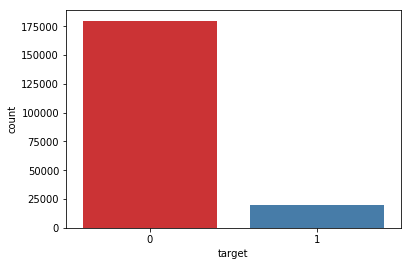

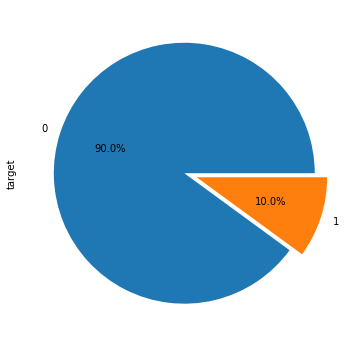

In [8]:
# Digging target variable
target = train['target']
print('Different values in target:\n',target.value_counts())
print('')
print("There are {}% target values with 1".format(100 *target.value_counts()[1]/(target.value_counts()[1] + target.value_counts()[0])))

sns.countplot(train['target'], palette='Set1')

plt.figure(figsize=(10,6))
train['target'].value_counts().plot.pie(autopct='%1.1f%%', explode=([0,0.1]))
plt.show()


<b>Observation:
    
 > Only about 10% of total target is belong to class 1, therefore , this train dataset is imbalanced, hence need different sampling methods than random sampling.
 
1. We have to solve an imbalanced class problem. The number of customers that will not make a transaction is much higher than those that will.
2. It seem that there is no relationship of the target with the index of the train dataframe. This is more empressend by the zero targets than for the ones.

### <a id='2.1.2.2'>2.1.2.2 Outlier Analysis: Boxplot</a>

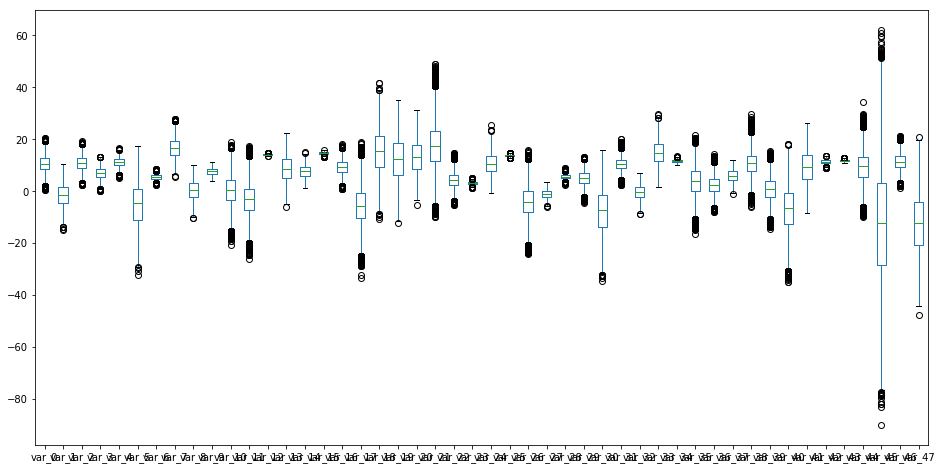

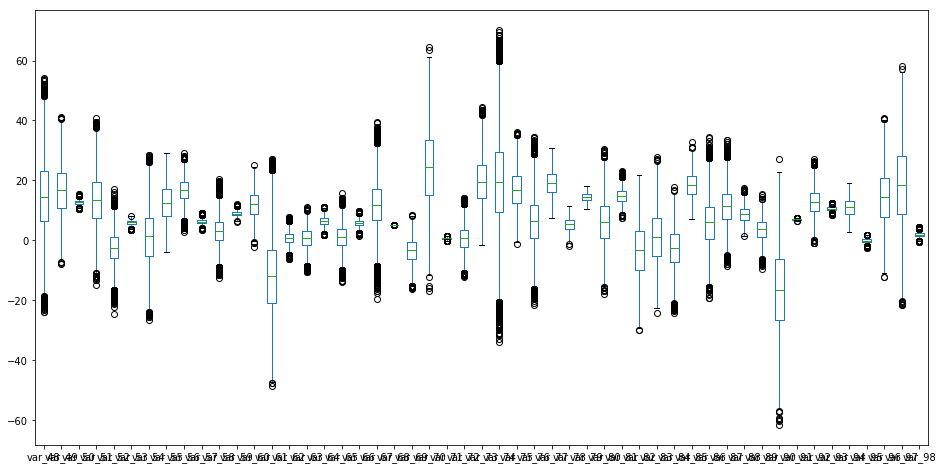

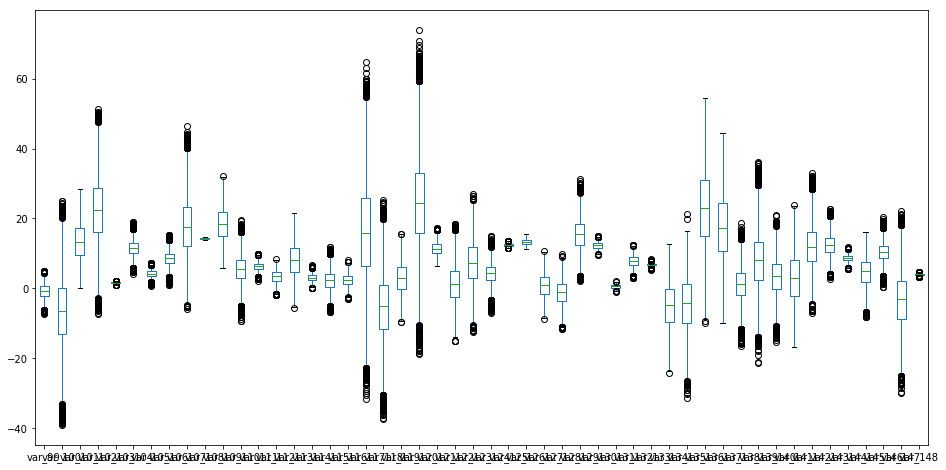

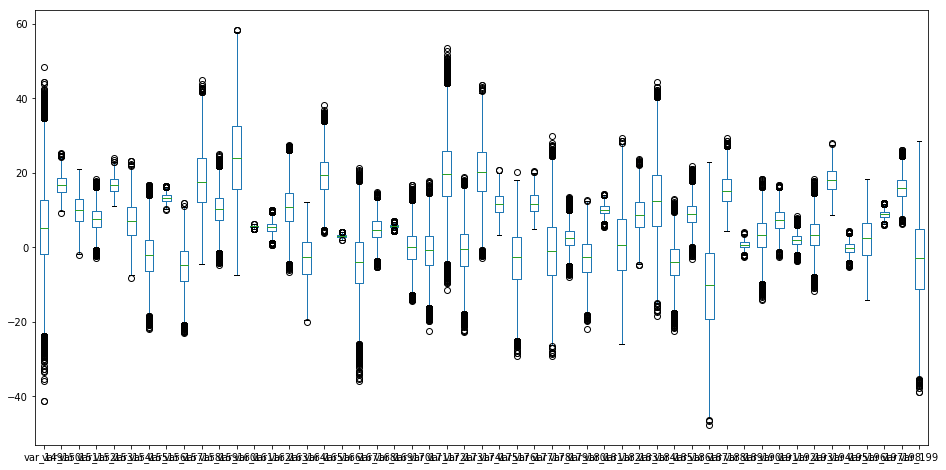

In [9]:
# Boxplot Analysis
# Plot  features.
train.iloc[:, 2:50].plot(kind='box', figsize=[16,8])
train.iloc[:, 50:101].plot(kind='box', figsize=[16,8])
train.iloc[:, 101:151].plot(kind='box', figsize=[16,8])
train.iloc[:, 151:].plot(kind='box', figsize=[16,8])


<b>Observations:
    
   1. Most of the data have outlier and range of the data variables is high.
   2. Data need to be free from ouliers and need to be scaled before applying any outlier senstive model algorithms.

### <a id='2.1.2.3'>2.1.2.3 Attributes Distributions and trends </a>

In [10]:
# Distribution plot Analysis

# Function for quick plot of distribution
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show() 
    
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]



<Figure size 432x288 with 0 Axes>

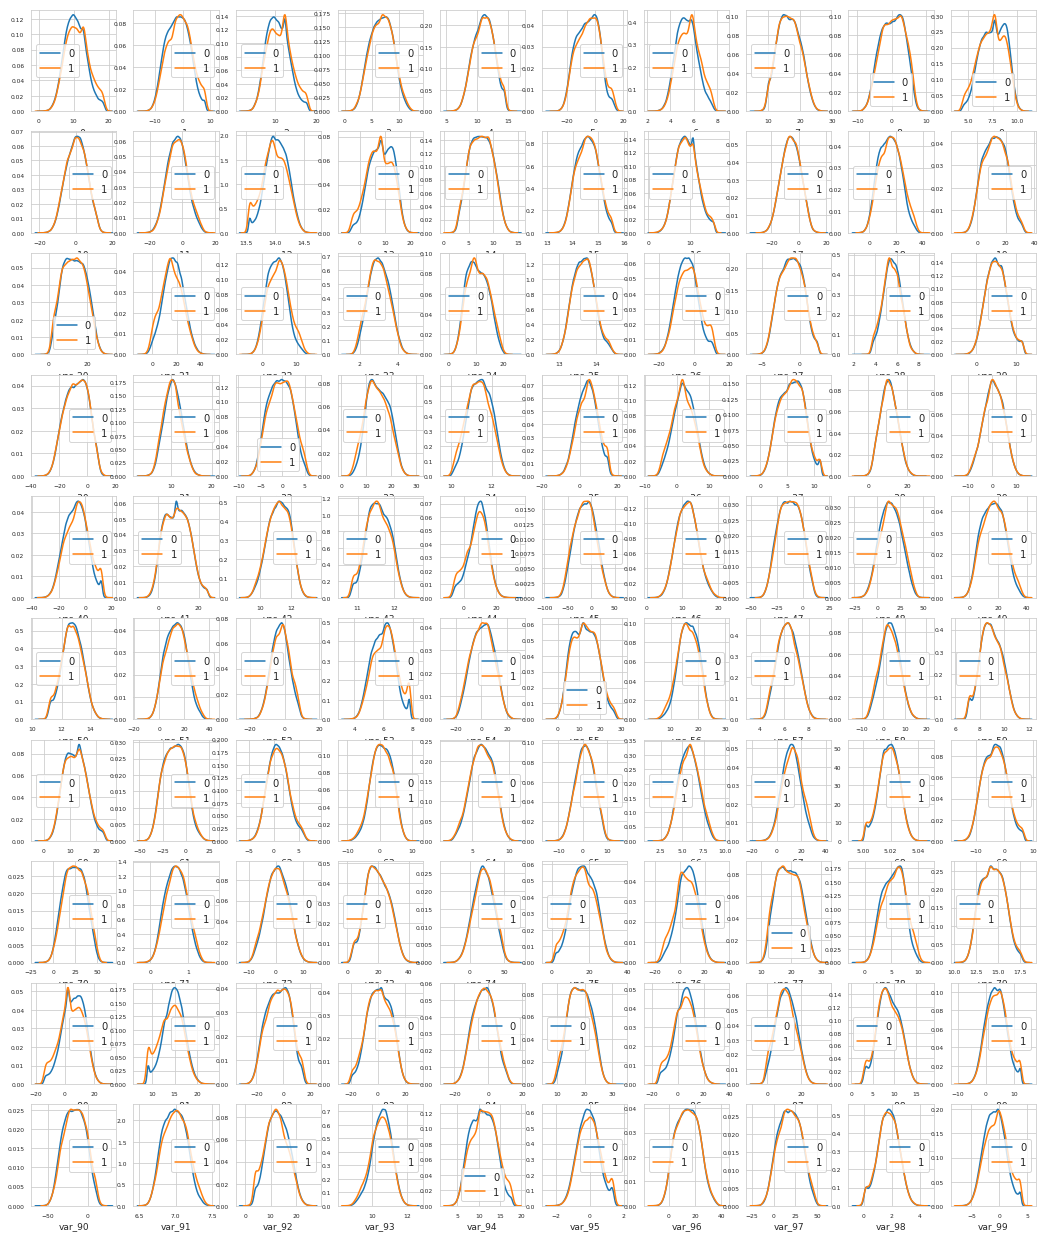

<Figure size 432x288 with 0 Axes>

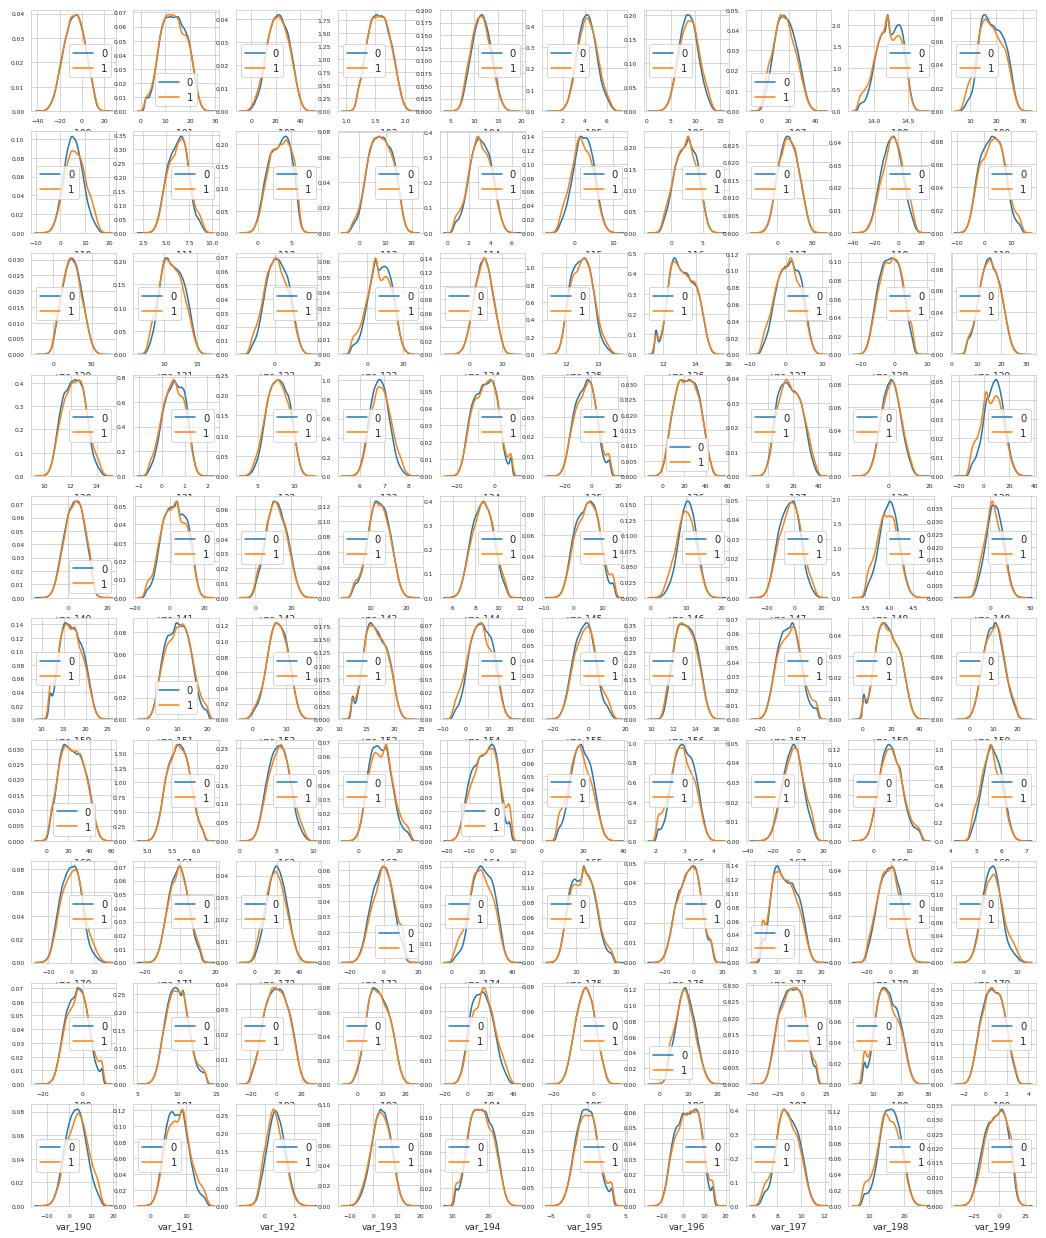

In [11]:

# First 100 features dustribution
features = train.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

# Rest 100 features dustribution
features = train.columns.values[102:]
plot_feature_distribution(t0, t1, '0', '1', features)



<b>Observations:
    
There is a considerable number of features with significant different distribution for the two target values.
For example, var_0, var_1, var_2, var_5, var_9, var_13, var_106, var_109, var_139 and many others.


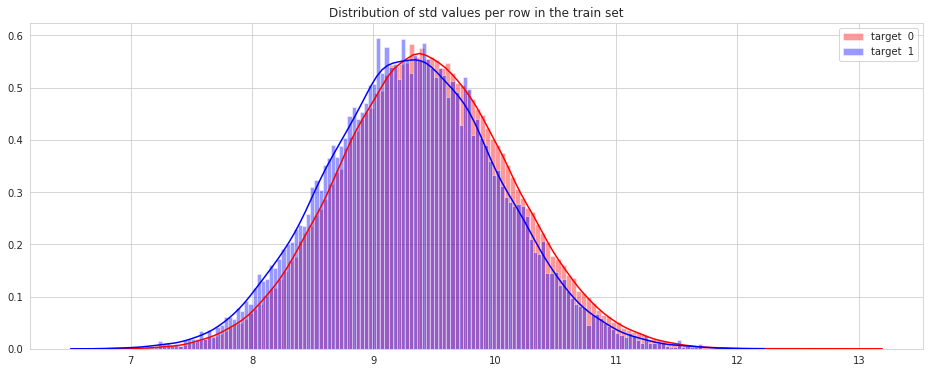

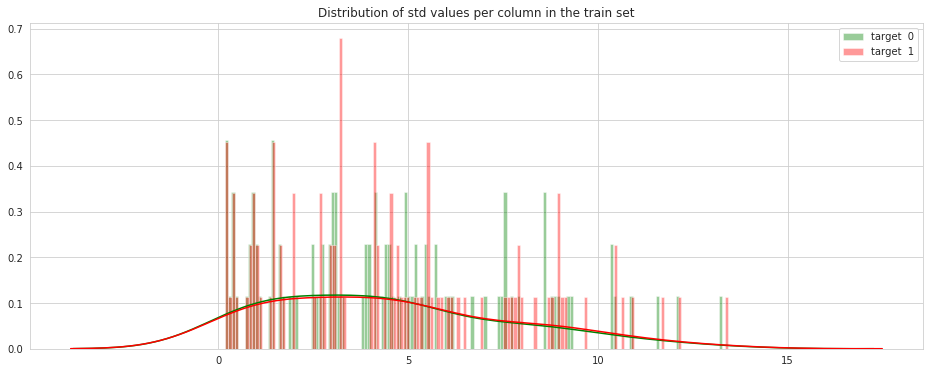

In [12]:

# 1. STD distribution of target variable

t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]

plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train set")
sns.distplot(t0[features].std(axis=1),color="red", kde=True,bins=150, label='target  0')
sns.distplot(t1[features].std(axis=1),color="blue", kde=True,bins=150, label='target  1')
plt.legend()
plt.show()

plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train set")
sns.distplot(t0[features].std(axis=0),color="green", kde=True,bins=150, label='target  0')
sns.distplot(t1[features].std(axis=0),color="red", kde=True,bins=150, label='target  1')
plt.legend()
plt.show()



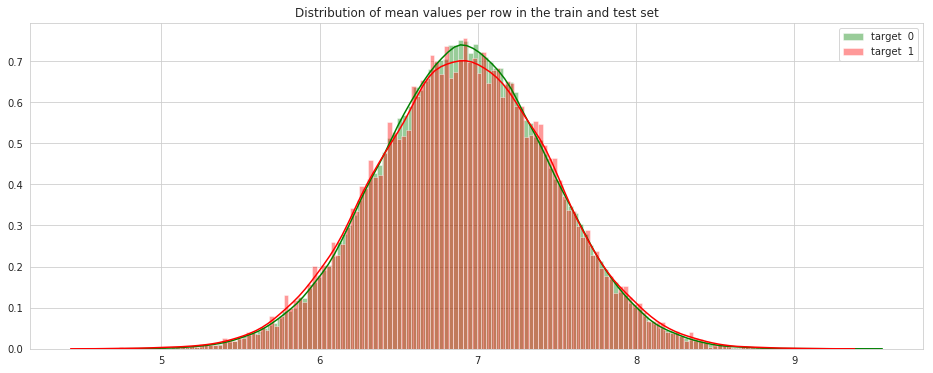

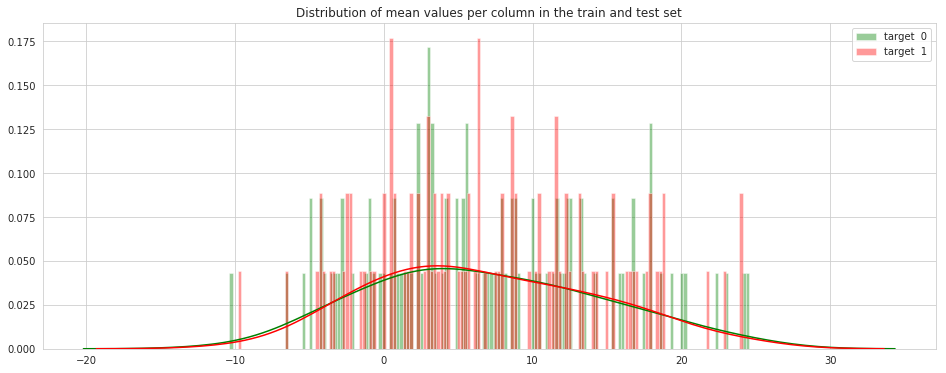

In [13]:

# 2. Mean distribution of target variable
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(t0[features].mean(axis=1),color="green", kde=True,bins=150, label='target  0')
sns.distplot(t1[features].mean(axis=1),color="red", kde=True,bins=150, label='target  1')
plt.legend()
plt.show()

plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(t0[features].mean(axis=0),color="green", kde=True,bins=150, label='target  0')
sns.distplot(t1[features].mean(axis=0),color="red", kde=True,bins=150, label='target  1')
plt.legend()
plt.show()


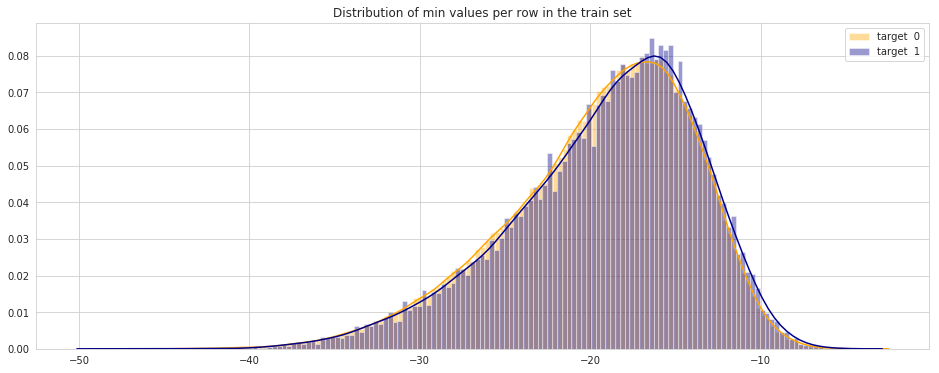

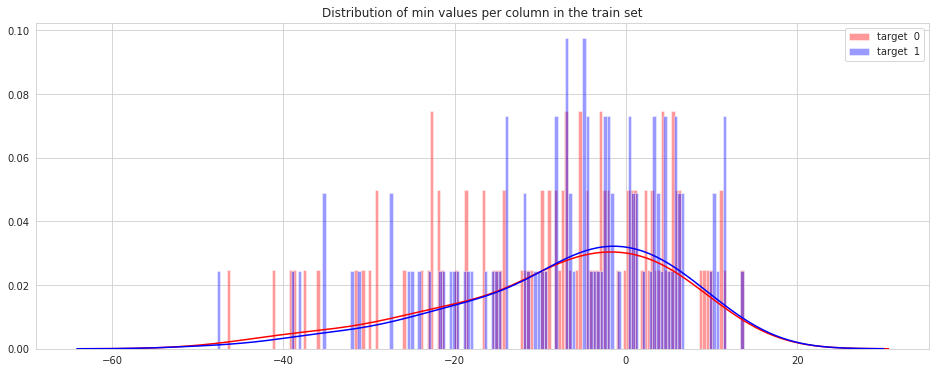

In [14]:

# 3. Min distribution
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per row in the train set")
sns.distplot(t0[features].min(axis=1),color="orange", kde=True,bins=150, label='target  0')
sns.distplot(t1[features].min(axis=1),color="darkblue", kde=True,bins=150, label='target  1')
plt.legend()
plt.show()

plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train set")
sns.distplot(t0[features].min(axis=0),color="red", kde=True,bins=150, label='target  0')
sns.distplot(t1[features].min(axis=0),color="blue", kde=True,bins=150, label='target  1')
plt.legend()
plt.show()


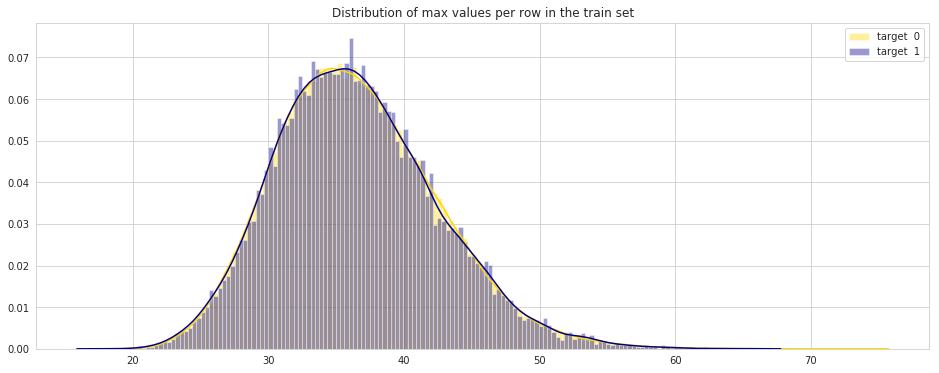

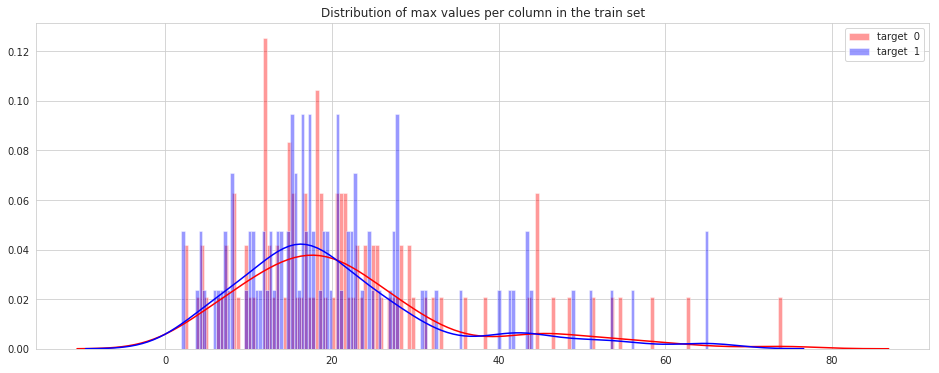

In [15]:

# 4. Max distribution
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train set")
sns.distplot(t0[features].max(axis=1),color="gold", kde=True,bins=150, label='target  0')
sns.distplot(t1[features].max(axis=1),color="darkblue", kde=True,bins=150, label='target  1')
plt.legend()
plt.show()

plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train set")
sns.distplot(t0[features].max(axis=0),color="red", kde=True,bins=150, label='target  0')
sns.distplot(t1[features].max(axis=0),color="blue", kde=True,bins=150, label='target  1')
plt.legend()
plt.show()


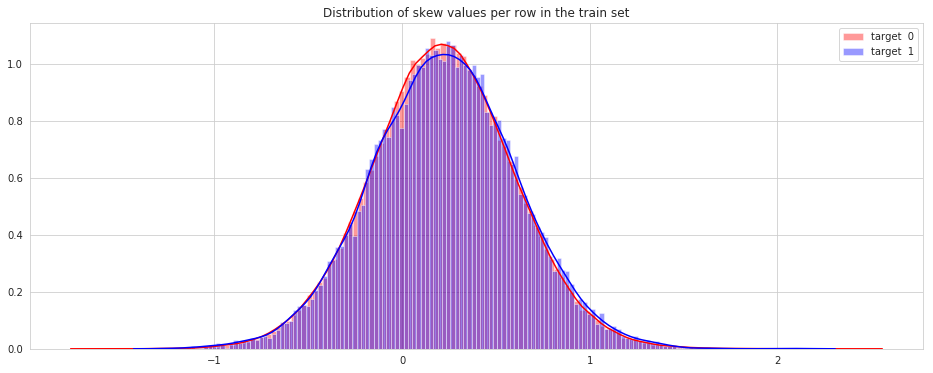

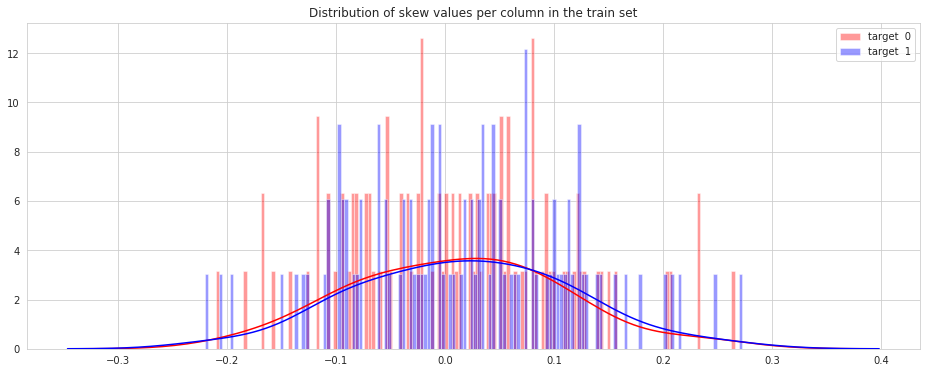

In [16]:

# 5. Skew distribution
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[features].skew(axis=1),color="red", kde=True,bins=150, label='target  0')
sns.distplot(t1[features].skew(axis=1),color="blue", kde=True,bins=150, label='target  1')
plt.legend()
plt.show()

plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per column in the train set")
sns.distplot(t0[features].skew(axis=0),color="red", kde=True,bins=150, label='target  0')
sns.distplot(t1[features].skew(axis=0),color="blue", kde=True,bins=150, label='target  1')
plt.legend()
plt.show()



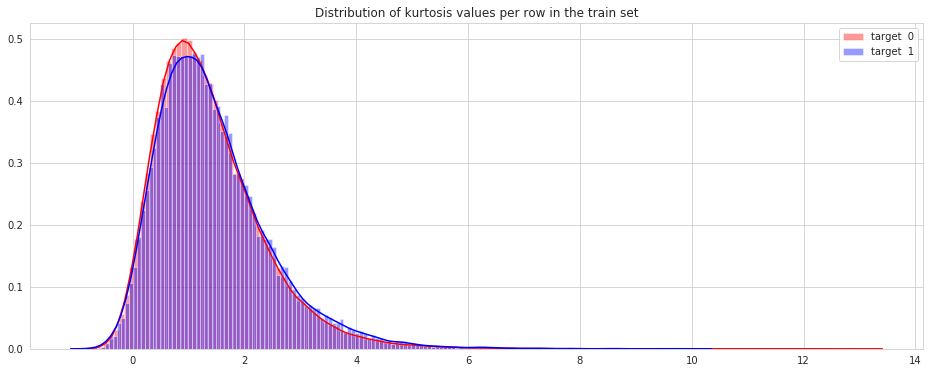

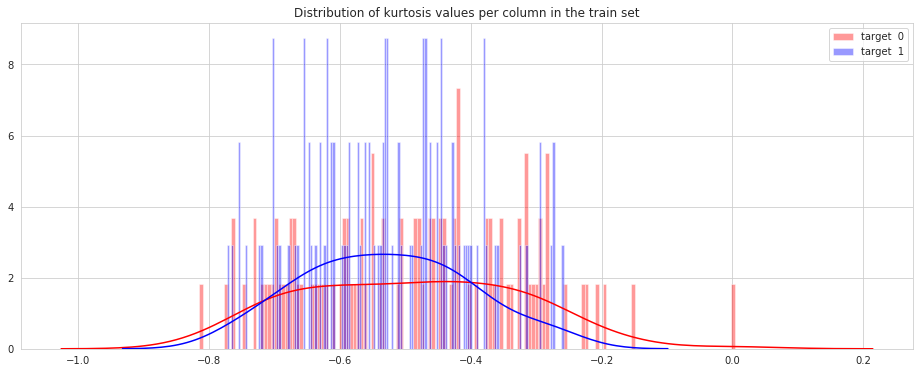

In [17]:

# 6. Kurtosis distribution
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per row in the train set")
sns.distplot(t0[features].kurtosis(axis=1),color="red", kde=True,bins=150, label='target  0')
sns.distplot(t1[features].kurtosis(axis=1),color="blue", kde=True,bins=150, label='target  1')
plt.legend()
plt.show()

plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per column in the train set")
sns.distplot(t0[features].kurtosis(axis=0),color="red", kde=True,bins=150, label='target  0')
sns.distplot(t1[features].kurtosis(axis=0),color="blue", kde=True,bins=150, label='target  1')
plt.legend()
plt.show()


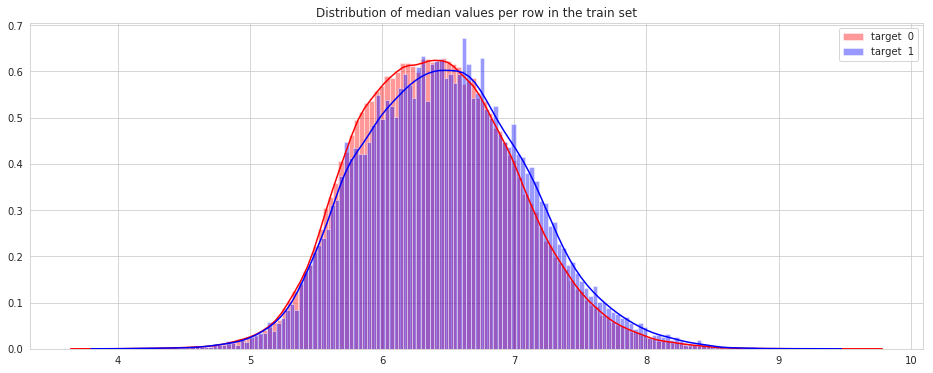

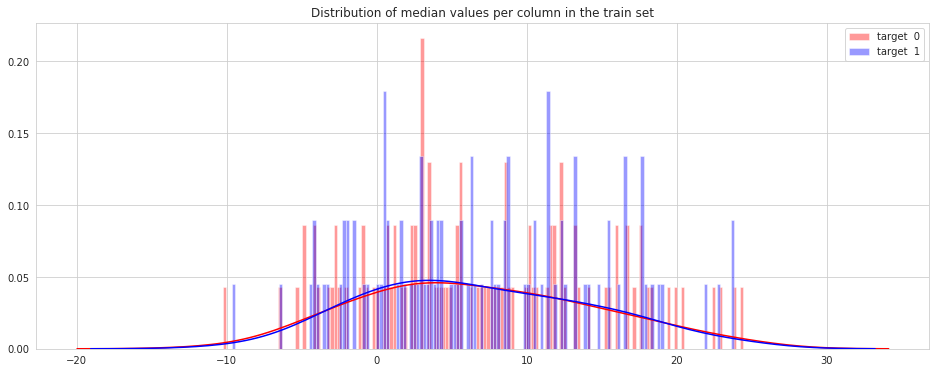

In [18]:

# 7. Median distribution
plt.figure(figsize=(16,6))
plt.title("Distribution of median values per row in the train set")
sns.distplot(t0[features].median(axis=1),color="red", kde=True,bins=150, label='target  0')
sns.distplot(t1[features].median(axis=1),color="blue", kde=True,bins=150, label='target  1')
plt.legend()
plt.show()

plt.figure(figsize=(16,6))
plt.title("Distribution of median values per column in the train set")
sns.distplot(t0[features].median(axis=0),color="red", kde=True,bins=150, label='target  0')
sns.distplot(t1[features].median(axis=0),color="blue", kde=True,bins=150, label='target  1')
plt.legend()
plt.show()


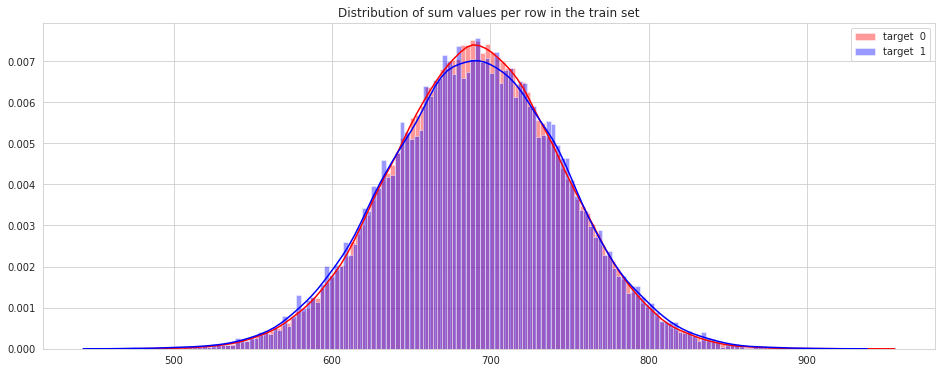

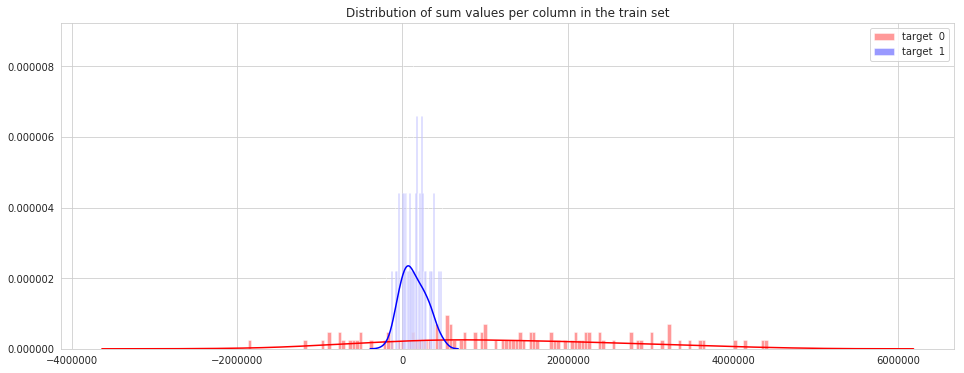

In [19]:

# 8. Sum distribution
plt.figure(figsize=(16,6))
plt.title("Distribution of sum values per row in the train set")
sns.distplot(t0[features].sum(axis=1),color="red", kde=True,bins=150, label='target  0')
sns.distplot(t1[features].sum(axis=1),color="blue", kde=True,bins=150, label='target  1')
plt.legend()
plt.show()

plt.figure(figsize=(16,6))
plt.title("Distribution of sum values per column in the train set")
sns.distplot(t0[features].sum(axis=0),color="red", kde=True,bins=150, label='target  0')
sns.distplot(t1[features].sum(axis=0),color="blue", kde=True,bins=150, label='target  1')
plt.legend()
plt.show()


<b> Observation: </b>
There are some significant differences in aggregate values. 

### <a id='2.1.2.4'>2.1.2.4 Correlation Analysis / Heatmap</a>
### Multi-variate
1. Scatter plots
2. Correlation matrix


First, we will use the method corr() on a DataFrame that calculates the correlation between each pair of features. Then, we pass the resulting correlation matrix to heatmap() from seaborn, which renders a color-coded matrix for the provided values:

In [20]:

# Correlation Analysis
data_corr=train.drop(['target','ID_code'], axis=1).corr()
print('Maximum corr within all variables correlations :', np.sort(train.drop(['target','ID_code'], axis=1).corr())[:,-2:-1].max())


Maximum corr within all variables correlations : 0.009713658349534146


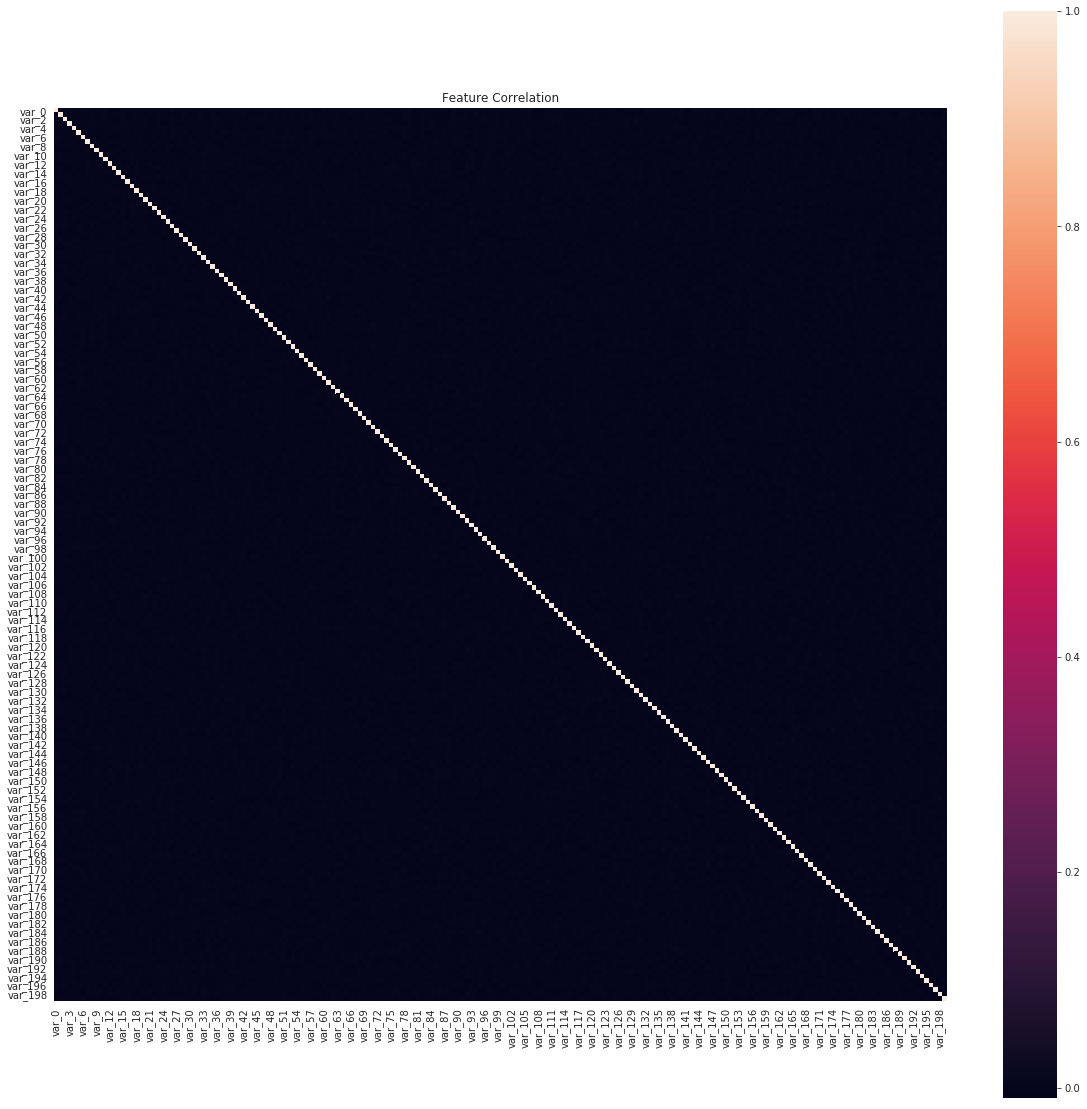

In [21]:

# Correlation Heatmap
plt.figure(figsize=(20,20))
sns.heatmap(data_corr, square=True)
plt.title('Feature Correlation')
plt.show()


<b>Observations:
    
 > Maximum corr within all variables correlations is 0.009713 which is inferior, and hence, all the variables are almost independent i.e. no correlation between them. Therefore, we should not ignore direclty any variable or drop it in feature selection preocess.

# <a id='2.2'>2.2 Data Preprocessing</a

Data preprocessing is a crucial step for any data analysis problem. Data Preprocessing is a technique that is used to convert the raw data into a clean data set. In other words, whenever the data is gathered from different sources it is collected in raw format which is not feasible for the analysis. It is an integral step in Machine Learning as the quality of data and the useful information that can be derived from it directly affects the ability of our model to learn; therefore, it is extremely important that we preprocess our data before feeding it into our model.

This involves a number of activities such as:
* Assigning numerical values to categorical data;
* Handling missing values; and
* Normalizing the features (so that features on small scales do not dominate when fitting a model to the data).

Methods can be used:
* Handling Null Values
* Standardization
* Handling Categorical Variables
* One-Hot Encoding
* Multicollinearity

### <a id='2.2.1'>2.2.1 Outlier Handling</a>

In [22]:
# Data Preprocessiing

# Remove outliers
train_x = train.iloc[:, 1:]
IQR = train_x.quantile(.75) - train_x.quantile(.25)
print("Train.shape:",train.shape)
df_in = train[~((train_x < (train_x.quantile(.25) - 1.5 * IQR)) |(train_x > (train_x.quantile(.75) + 1.5 * IQR))).any(axis=1)]
df_out = train[((train_x < (train_x.quantile(.25) - 1.5 * IQR)) |(train_x > (train_x.quantile(.75) + 1.5 * IQR))).any(axis=1)]
print("df_in.shape:",df_in.shape)
print("df_out.shape:",df_out.shape)

Train.shape: (200000, 202)
df_in.shape: (157999, 202)
df_out.shape: (42001, 202)


In [23]:
print("df_in.target:\n", df_in['target'].value_counts())
print("df_out.target:\n", df_out['target'].value_counts())

df_in.target:
 0    157999
Name: target, dtype: int64
df_out.target:
 0    21903
1    20098
Name: target, dtype: int64


1. <b>Observation: </b>
All the outliers include our class1 target, so we cannot remove them.

### <a id='2.2.2'>2.2.2 Principal component analysis (PCA)</a>


#### Feature decomposition using Principal Component Analysis ( PCA )  || Feature Extraction

Principal Component Analysis (PCA) is a linear dimensionality reduction technique that can be utilized for extracting information from a high-dimensional space by projecting it into a lower-dimensional sub-space. It tries to preserve the essential parts that have more variation of the data and remove the non-essential parts with fewer variation.

From the pair plot in Visualization, lot of feature pairs divide nicely the data to a similar extent, therefore, it makes sense to use one of the dimensionality reduction methods to try to use as many features as possible and maintian as much information as possible when working with only 2 dimensions. 

PCA is very sensitive to unstandardize data therefore we should use scaled version of our data for feature extraction. 

##### Deciding How Many Principal Components to Retain

In order to decide how many principal components should be retained, it is common to summarise the results of a principal components analysis by making a scree plot.

Using Elbow Method to determine the right number of components to be retain.

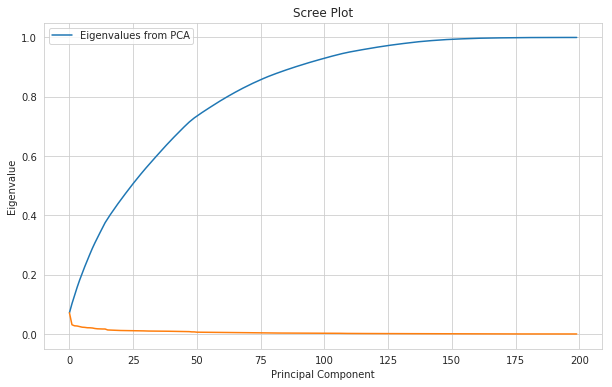

In [24]:
# PCA Analysis


# feature extraction
pca = PCA().fit(train.drop(['target','ID_code'], axis=1))

plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.plot(pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
leg = plt.legend(['Eigenvalues from PCA'], loc='best', borderpad=0.3,shadow=False,markerscale=0.4)
plt.grid(True)
plt.show()

<b>Observation:</b>
    
* Here, the non scaled version of our data is working much better than  scaled version data. Although, PCA strongly avert non scaled version input but for now we will consider it during our modeling

* Only 100 components can explain our 50+ % of features.

### <a id='2.2.3'>2.2.3 Feature Selection </a>
### Finding top features using ML Algos
We will use ML algorithms to find the top features from data variables. They can serve as a starting point to discover their nature and for trying to understand the data. In addition they may yield some ideas on how to generate new features. I am going to use GridSearchCV strategy for. Since, our target is imbalanced.

1. Imbalanced dataset is relevant primarily in the context of supervised machine learning involving two or more classes.

2. Imbalance means that the number of data points available for different the classes is different

We will look into using following algorithm:
* Random Forest Classfier

Here, after we will remove 25 less significant features from our dataset use RFC.

In [25]:
# Using Stratified sampling
X_train, X_test, y_train, y_test = train_test_split(train.drop(['target', 'ID_code'], axis=1), train['target'], test_size=0.3, random_state=147, stratify=train.target)
print('Shape:',X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Shape: (140000, 200) (60000, 200) (140000,) (60000,)


In [26]:


parameters = {'min_samples_leaf': [10,25]}
forest = RandomForestClassifier(max_depth=15, n_estimators=15)
grid_rfc = GridSearchCV(forest, parameters, cv=3, n_jobs=1, verbose=3, scoring=make_scorer(roc_auc_score))
grid_rfc.fit(X_train, y_train)
imp = grid_rfc.best_estimator_.feature_importances_
idx = np.argsort(imp)[::-1][-26:]

remove_features_RFC = train.columns[2:]
#train.drop(remove_features_RFC[idx],axis=1, inplace=True)
#test.drop(remove_features_RFC[idx],axis=1, inplace=True)
remove_col = remove_features_RFC[idx]
print('Removing features:', remove_col)
print('Train shape:',train.shape)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] min_samples_leaf=10 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. min_samples_leaf=10, score=0.500, total=  29.4s
[CV] min_samples_leaf=10 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.4s remaining:    0.0s


[CV] ................. min_samples_leaf=10, score=0.500, total=  29.8s
[CV] min_samples_leaf=10 .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   59.2s remaining:    0.0s


[CV] ................. min_samples_leaf=10, score=0.500, total=  29.6s
[CV] min_samples_leaf=25 .............................................
[CV] ................. min_samples_leaf=25, score=0.500, total=  29.2s
[CV] min_samples_leaf=25 .............................................
[CV] ................. min_samples_leaf=25, score=0.500, total=  29.8s
[CV] min_samples_leaf=25 .............................................
[CV] ................. min_samples_leaf=25, score=0.500, total=  29.4s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.0min finished


Removing features: Index(['var_136', 'var_144', 'var_77', 'var_120', 'var_187', 'var_189',
       'var_61', 'var_68', 'var_74', 'var_41', 'var_182', 'var_183', 'var_38',
       'var_72', 'var_185', 'var_150', 'var_14', 'var_160', 'var_124',
       'var_98', 'var_10', 'var_73', 'var_117', 'var_45', 'var_27', 'var_42'],
      dtype='object')
Train shape: (200000, 202)


In [27]:
remove_col = ['var_187', 'var_113', 'var_7', 'var_126', 'var_189', 'var_62',
       'var_117', 'var_45', 'var_182', 'var_96', 'var_199', 'var_19', 'var_68',
       'var_77', 'var_3', 'var_25', 'var_14', 'var_41', 'var_73', 'var_30',
       'var_64', 'var_185', 'var_29', 'var_129', 'var_171', 'var_140']

trainFE = train.drop(remove_col,axis=1)
testFE = test.drop(remove_col,axis=1)
print('Removing features:', remove_col)
print('Columns left in Train :',trainFE.shape)
print('Columns left in Test :',testFE.shape)

Removing features: ['var_187', 'var_113', 'var_7', 'var_126', 'var_189', 'var_62', 'var_117', 'var_45', 'var_182', 'var_96', 'var_199', 'var_19', 'var_68', 'var_77', 'var_3', 'var_25', 'var_14', 'var_41', 'var_73', 'var_30', 'var_64', 'var_185', 'var_29', 'var_129', 'var_171', 'var_140']
Columns left in Train : (200000, 176)
Columns left in Test : (200000, 175)


Observation: We are not removing feature because we might loose some performance.

### <a id='2.2.4'>2.2.4 Feature Engineering</a>
<B> Adding our aggregate features to dataset

In [28]:

print('Featuring Engineering raw data: Adding aggregates :')
idx = features = train.columns[2:]
for df in [test, train]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

print('Train:', train.shape)
print('Test:' , test.shape)

Featuring Engineering raw data: Adding aggregates :
Train: (200000, 210)
Test: (200000, 209)


<Figure size 432x288 with 0 Axes>

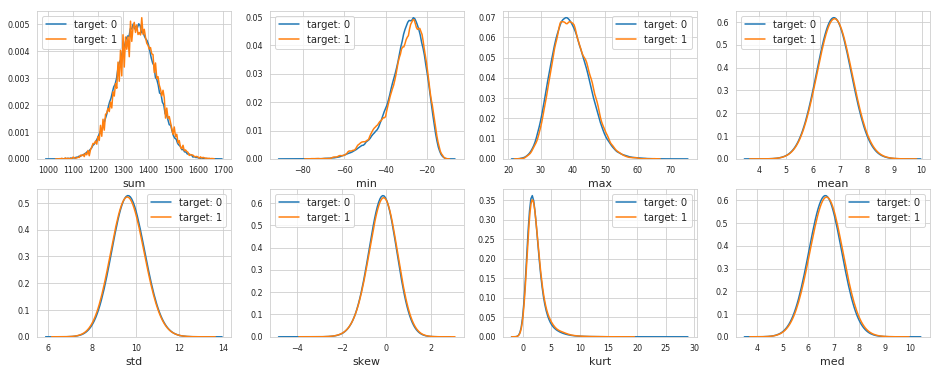

In [29]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(16,6))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
features = train.columns.values[202:]
plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

In [30]:

X_train, X_test, y_train, y_test = train_test_split(train.drop(['target','ID_code'], axis=1), train.target, test_size=0.3, random_state=147, stratify=train.target)

print('Shape:',X_train.shape, X_test.shape, y_train.shape, y_test.shape)


Shape: (140000, 208) (60000, 208) (140000,) (60000,)


## <a id='2.3'>2.3 Modeling</a>

### <a id='2.3.1'>2.3.1 Classifiation Models( KFold without scaling)</a>

Using Logistic Regression, DecisionTreeClassifier, GaussianNB, and RandomForestClassifier as a classifer and applying KFold for cross validation.

In [31]:
# Spot-Check Algorithms
models = []
models.append(( 'LR' , LogisticRegression(solver='liblinear')))
models.append(( 'CART' , DecisionTreeClassifier()))
models.append(( 'NB' , GaussianNB()))
models.append(('RFC', RandomForestClassifier()))


In [32]:
def cv_auc_score(models,scoring, num_folds=3):
    seed = 147 
    results = []
    names = []
    
    print('-> 3-Fold cross-validation ',scoring.__name__,'score for the training data for 4 classifiers.')
    for name, model in models:
        kfold = KFold( n_splits=num_folds, random_state=seed)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold,verbose=3 ,scoring=make_scorer(scoring))
        results.append(cv_results)
        names.append(name)
        print("Algo: ", name,'::',np.mean(cv_results))
    
    # Compare Algorithms
    fig = plt.figure()

    fig.suptitle( 'Algorithm Comparison: {}'.format(scoring.__name__ ))
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()




### Model run with 4 classifier without applying Standardization on data.

Scores without StandardScale
-> 3-Fold cross-validation  roc_auc_score score for the training data for 4 classifiers.
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.631, total=  56.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.2s remaining:    0.0s


[CV] .................................... , score=0.636, total=  57.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


[CV] .................................... , score=0.637, total=  57.8s
Algo:  LR :: 0.634542682834447
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.555, total= 2.5min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s


[CV] .................................... , score=0.560, total= 2.4min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.9min remaining:    0.0s


[CV] .................................... , score=0.559, total= 2.5min
Algo:  CART :: 0.5579319195335598
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.671, total=   1.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] .................................... , score=0.676, total=   1.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV] .................................... , score=0.679, total=   1.0s
Algo:  NB :: 0.6753558903368968
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.507, total=  52.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.5s remaining:    0.0s


[CV] .................................... , score=0.505, total=  51.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


[CV] .................................... , score=0.506, total=  51.6s
Algo:  RFC :: 0.5060705451782948


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.6min finished


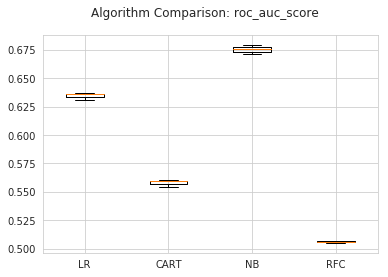

In [33]:
# AUC score
num_folds = 3
scoring=roc_auc_score
print("Scores without StandardScale")
cv_auc_score(models, scoring=scoring, num_folds=num_folds)

Scores without StandardScale
-> 3-Fold cross-validation  accuracy_score score for the training data for 4 classifiers.
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.913, total=  56.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.4s remaining:    0.0s


[CV] .................................... , score=0.918, total=  57.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


[CV] .................................... , score=0.915, total=  58.3s
Algo:  LR :: 0.9150571394811041
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.832, total= 2.4min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s


[CV] .................................... , score=0.838, total= 2.4min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.8min remaining:    0.0s


[CV] .................................... , score=0.834, total= 2.5min
Algo:  CART :: 0.8347142839116927
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.917, total=   1.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] .................................... , score=0.921, total=   1.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV] .................................... , score=0.918, total=   1.0s
Algo:  NB :: 0.9185928548386154
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.899, total=  53.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.9s remaining:    0.0s


[CV] .................................... , score=0.902, total=  52.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s


[CV] .................................... , score=0.898, total=  56.0s
Algo:  RFC :: 0.8996714163162055


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.7min finished


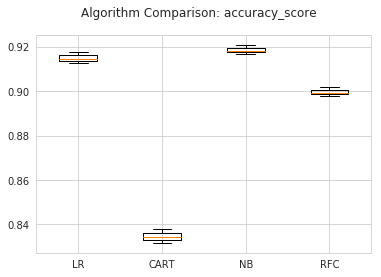

In [34]:
# Accuracy score
scoring =  accuracy_score
print("Scores without StandardScale")
cv_auc_score(models, scoring=scoring, num_folds=num_folds)

In [35]:
def aur_prob_value_precision_recall_curve(models, X_train,  X_test,y_train, y_test):
    for name, model in models:
        model.fit(X_train, y_train)
        
        y_pred = model.predict_proba(X_test)
        y_pred2 = model.predict(X_test)
        
        print(name,' AUC prob: ',roc_auc_score(y_test, y_pred[:,1]))
        print(name,' AUC value: ',roc_auc_score(y_test, y_pred2))
        print(name,' f1 score: ',f1_score(y_test, y_pred2))
        
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])
        fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
        fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred2)
        
        fig, ax = plt.subplots(1,1, figsize=(6,6))  
        ax.plot(precision, recall)
        ax.plot(fpr, tpr, color='red')
        ax.plot(fpr2, tpr2, color='green')
        ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6)) 
        ax.legend([f'Precision-recall: {auc(recall, precision)}',f'AUC Prob: {auc(fpr, tpr)}',f'AUC Value: {auc(fpr2, tpr2)}'])
       # ax.legned()
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Receiver operating characteristic {}'.format(name))


In [36]:
def classification_report_models(models,X_train, X_test, y_train, y_test ):
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(name, ':\n', confusion_matrix(y_test, y_pred))
        print(name,':\n',classification_report(y_test, y_pred))

AUC curve (Prob and Value) without StandardScale
LR  AUC prob:  0.865215738698051
LR  AUC value:  0.6348121385191046
LR  f1 score:  0.4033077377436503
CART  AUC prob:  0.55773344782241
CART  AUC value:  0.55773344782241
CART  f1 score:  0.20424232685200064
NB  AUC prob:  0.8834591938006527
NB  AUC value:  0.672206132373744
NB  f1 score:  0.47192699946323136
RFC  AUC prob:  0.6950275068782678
RFC  AUC value:  0.5055440934705913
RFC  f1 score:  0.02399870277282309
LR :
 [[53242   729]
 [ 4322  1707]]
LR :
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     53971
           1       0.70      0.28      0.40      6029

    accuracy                           0.92     60000
   macro avg       0.81      0.63      0.68     60000
weighted avg       0.90      0.92      0.90     60000

CART :
 [[48864  5107]
 [ 4785  1244]]
CART :
               precision    recall  f1-score   support

           0       0.91      0.91      0.91     53971
       

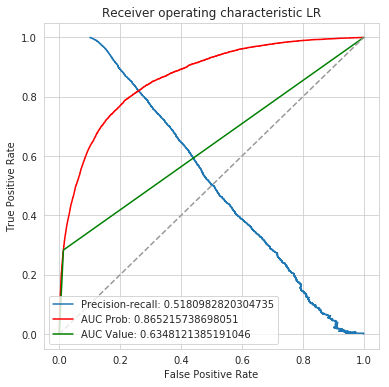

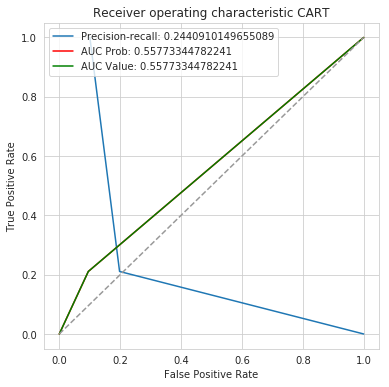

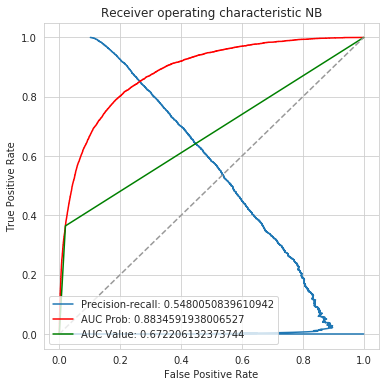

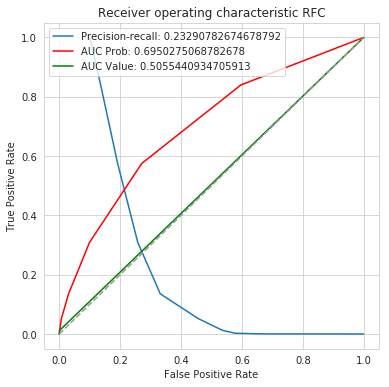

In [37]:
print("AUC curve (Prob and Value) without StandardScale")
aur_prob_value_precision_recall_curve(models=models, X_train = X_train, X_test= X_test, y_train=y_train, y_test=y_test)
classification_report_models(models=models, X_train = X_train, X_test= X_test, y_train=y_train, y_test=y_test)

<b> Observation: </b>
    LR and GaussianNB are better as compare to others.

### <a id='2.3.2'>2.3.2 KFold with scaled and SMOTE Oversampling sampling data</a>
### Model run with 4 classifier with applying Standardization, StratifiedKFlod and SMOTE oversampling on data.

In [38]:

tr_X = train.drop([ 'ID_code'], axis=1)
test_X = test.drop(['ID_code'], axis=1)
for col in tr_X.drop(['target'], axis=1).columns:
    tr_X[col] = ((tr_X[col] - tr_X[col].mean()) / tr_X[col].std()).astype('float32')
for col in test_X.columns:
    test_X[col] = ((test_X[col] - test_X[col].mean()) / test_X[col].std()).astype('float32')
  

#Training data
X=tr_X.drop(['target'],axis=1)
Y=train['target']
#StratifiedKFold cross validator
cv=StratifiedKFold(n_splits=5,random_state=147,shuffle=True)
for train_index,valid_index in cv.split(X,Y):
    X_train1, X_valid=X.iloc[train_index], X.iloc[valid_index]
    y_train1, y_valid=Y.iloc[train_index], Y.iloc[valid_index]

print('Shape of X_train :',X_train1.shape)
print('Shape of X_valid :',X_valid.shape)
print('Shape of y_train :',y_train1.shape)
print('Shape of y_valid :',y_valid.shape)

Shape of X_train : (160001, 208)
Shape of X_valid : (39999, 208)
Shape of y_train : (160001,)
Shape of y_valid : (39999,)


In [39]:
from imblearn.over_sampling import SMOTE
#Synthetic Minority Oversampling Technique
sm = SMOTE(random_state=147, ratio=1.0)
#Generating synthetic data points
X_smote,y_smote=sm.fit_sample(X_train1,y_train1)
X_smote_v,y_smote_v=sm.fit_sample(X_valid,y_valid)

AUC curve (Prob and Value) with Standardization and SMOTE oversampling
LR  AUC prob:  0.8737706351901386
LR  AUC value:  0.794260700389105
LR  f1 score:  0.7948508320977732
CART  AUC prob:  0.6213868816008894
CART  AUC value:  0.6213868816008894
CART  f1 score:  0.5657959743095288
NB  AUC prob:  0.9213071541505519
NB  AUC value:  0.8658282379099499
NB  f1 score:  0.8539709908193052
RFC  AUC prob:  0.7905172145695172
RFC  AUC value:  0.6858393551973319
RFC  f1 score:  0.5744404495228056
LR :
 [[28474  7506]
 [ 7299 28681]]
LR :
               precision    recall  f1-score   support

           0       0.80      0.79      0.79     35980
           1       0.79      0.80      0.79     35980

    accuracy                           0.79     71960
   macro avg       0.79      0.79      0.79     71960
weighted avg       0.79      0.79      0.79     71960

CART :
 [[26855  9125]
 [18261 17719]]
CART :
               precision    recall  f1-score   support

           0       0.60      0.75    

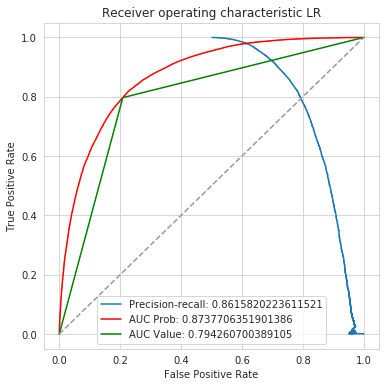

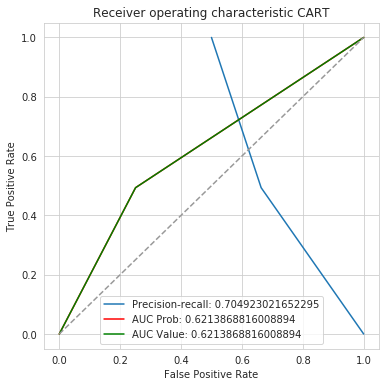

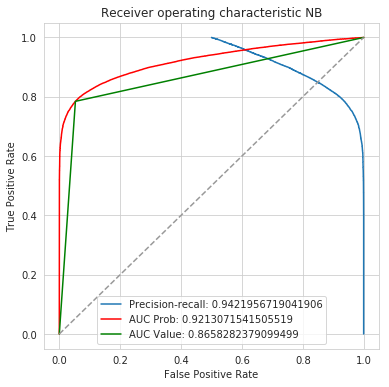

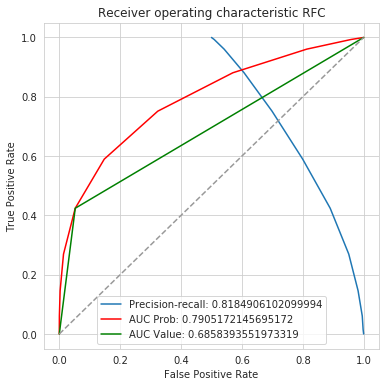

In [40]:
print("AUC curve (Prob and Value) with Standardization and SMOTE oversampling")
aur_prob_value_precision_recall_curve(models=models, X_train = X_smote, X_test= X_smote_v,  y_train=y_smote, y_test=y_smote_v)
classification_report_models(models=models, X_train = X_smote, X_test= X_smote_v, y_train=y_smote, y_test=y_smote_v)

https://stackoverflow.com/questions/44172162/f1-score-vs-roc-auc

As a rule of thumb, if the cost of having False negative is high, we want to increase the model sensitivity and recall!.

For instance, in fraud detection or sick patient detection, we don't want to label/predict a fraudulent transaction (True Positive) as non-fraudulent (False Negative). Also, we don't want to label/predict a contagious sick patient (True Positive) as not sick (False Negative).

This is because the consequences will be worse than a False Positive (incorrectly labelling a a harmless transaction as fraudulent or a non-contagious patient as contagious).

On the other hand, if the cost of having False Positive is high, then we want to increase the model specificity and precision!.

For instance, in email spam detection, we don't want to label/predict a non-spam email (True Negative) as spam (False Positive). On the other hand, failing to label a spam email as spam (False Negative) is less costly.

### <a id='2.3.3'>2.3.3 LightGBM</a>

Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks.

Since it is based on decision tree algorithms, it splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. Also, it is surprisingly very fast, hence the word ‘Light’.


#### Model building and training:
We need to convert our training data into LightGBM dataset format(this is mandatory for LightGBM training).
After creating a converting dataset, I created a python dictionary with parameters and their values. Accuracy of your model totally depends on the values you provide to parameters. I will use AUC and F1_score as performance metric of our algorithm.

We will perform three run for following different flavours
1. Training the model with simple train_test_split stratified data
2. Training the model with StratifiedKFold()+SMOTE() data

<b>#Training the model with simple train_test_split stratified data

In [41]:
#Training the model with simple train_test_split stratified data
#training data
lgb_train=lgb.Dataset(X_train,label=y_train)
#validation data
lgb_valid=lgb.Dataset(X_test,label=y_test)

In [42]:
params={'boosting_type': 'gbdt', 
          'max_depth' : -1, #no limit for max_depth if <0
          'objective': 'binary',
          'boost_from_average':False, 
          'nthread': 20,
          'metric':'auc',
          'num_leaves': 50,
          'learning_rate': 0.01,
          'max_bin': 100,      #default 255
          'subsample_for_bin': 100,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'bagging_fraction':0.5,
          'bagging_freq':5,
          'feature_fraction':0.08,
          'min_split_gain': 0.45, #>0
          'min_child_weight': 1,
          'min_child_samples': 5,
          'is_unbalance':True,
          }

In [43]:
# f1_score calculator function

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

evals_result = {}


In [44]:

num_rounds=1000
lgbm1= lgb.train(params,lgb_train,num_rounds,valid_sets=[lgb_train,lgb_valid],feval=lgb_f1_score,verbose_eval=100,early_stopping_rounds = 500)


Training until validation scores don't improve for 500 rounds.
[100]	training's auc: 0.909168	training's f1: 0.513711	valid_1's auc: 0.862795	valid_1's f1: 0.455253
[200]	training's auc: 0.920582	training's f1: 0.534648	valid_1's auc: 0.873125	valid_1's f1: 0.47007
[300]	training's auc: 0.924957	training's f1: 0.540702	valid_1's auc: 0.876815	valid_1's f1: 0.475495
[400]	training's auc: 0.928392	training's f1: 0.546953	valid_1's auc: 0.878633	valid_1's f1: 0.478254
[500]	training's auc: 0.932015	training's f1: 0.551476	valid_1's auc: 0.880548	valid_1's f1: 0.480557
[600]	training's auc: 0.935241	training's f1: 0.556326	valid_1's auc: 0.881902	valid_1's f1: 0.481913
[700]	training's auc: 0.93796	training's f1: 0.561914	valid_1's auc: 0.883328	valid_1's f1: 0.484938
[800]	training's auc: 0.940679	training's f1: 0.567985	valid_1's auc: 0.884574	valid_1's f1: 0.488597
[900]	training's auc: 0.942722	training's f1: 0.573896	valid_1's auc: 0.884792	valid_1's f1: 0.490933
[1000]	training's auc

Confusion matrix: Simple Lightgbm


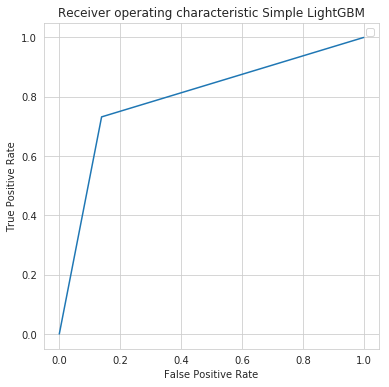

In [45]:
# confusion matrix
print('Confusion matrix: Simple Lightgbm')
confusion_matrix(y_test, lgbm1.predict(X_test).round())
def plot_roc(y_test, y_pred, name):
    fig, ax = plt.subplots(1,1, figsize=(6,6))  
    fpr2, tpr2, thresholds2 = roc_curve(y_test,  y_pred)
    ax.legend([f' {auc(fpr2, tpr2)}'])
           # ax.legned()
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic {}'.format(name))
    ax.plot(fpr2, tpr2)
plot_roc(y_test,  lgbm1.predict(X_test).round(), name='Simple LightGBM')

<b>#Training the model with StratifiedKFold()+SMOTE() data

In [46]:
#Training the model with StratifiedKFold()+SMOTE() data
#training data
lgb_train2=lgb.Dataset(X_smote,label=y_smote)
#validation data
lgb_valid2=lgb.Dataset(X_smote_v,label=y_smote_v)

In [47]:
num_rounds=10000
lgbm3= lgb.train(params,lgb_train2,num_rounds,valid_sets=[lgb_train2,lgb_valid2],feval=lgb_f1_score,verbose_eval=1000,early_stopping_rounds = 5000)


Training until validation scores don't improve for 5000 rounds.
[1000]	training's auc: 0.956035	training's f1: 0.885404	valid_1's auc: 0.934872	valid_1's f1: 0.85351
[2000]	training's auc: 0.969382	training's f1: 0.906532	valid_1's auc: 0.943806	valid_1's f1: 0.86739
[3000]	training's auc: 0.977731	training's f1: 0.921405	valid_1's auc: 0.94825	valid_1's f1: 0.873914
[4000]	training's auc: 0.983564	training's f1: 0.932759	valid_1's auc: 0.950809	valid_1's f1: 0.876921
[5000]	training's auc: 0.98797	training's f1: 0.94301	valid_1's auc: 0.952365	valid_1's f1: 0.8782
[6000]	training's auc: 0.991283	training's f1: 0.952102	valid_1's auc: 0.95335	valid_1's f1: 0.879392
[7000]	training's auc: 0.993806	training's f1: 0.960216	valid_1's auc: 0.954164	valid_1's f1: 0.879942
[8000]	training's auc: 0.995674	training's f1: 0.967558	valid_1's auc: 0.954826	valid_1's f1: 0.879562
[9000]	training's auc: 0.997011	training's f1: 0.973794	valid_1's auc: 0.955335	valid_1's f1: 0.879472
[10000]	training'

Confusion matrix: SMOTE Lightgbm


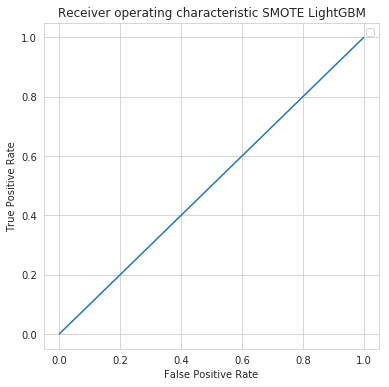

In [48]:
# confusion matrix
print('Confusion matrix: SMOTE Lightgbm')
confusion_matrix(y_test, lgbm3.predict(X_test).round())
plot_roc(y_test,  lgbm3.predict(X_test).round(), name='SMOTE LightGBM')


<B>Observation:</b>
Our model with StratifiedKFold()+SMOTE() data gives best result:
* training's auc: 0.997312	training's f1: 0.97558	valid_1's auc: 0.952837	valid_1's f1: 0.876571

Our model with simple train_test_split stratified data yield:
* training's auc: 0.990451	training's f1: 0.761308	valid_1's auc: 0.891113	valid_1's f1: 0.534388

In [49]:
#final submission

X_test=test.drop(['ID_code'],axis=1)
#predict the model, probability predictions
lightgbm_predict_prob3=lgbm3.predict(X_test,random_state=42,num_iteration=lgbm3.best_iteration)
lightgbm_predict_prob1=lgbm1.predict(X_test,random_state=42,num_iteration=lgbm1.best_iteration)

#Convert to binary output 1 or 0
lightgbm_predict3=lightgbm_predict_prob3.round()
lightgbm_predict1=lightgbm_predict_prob1.round()


In [50]:
submit=pd.DataFrame({'ID_code':test['ID_code'].values})
submit1=pd.DataFrame({'ID_code':test['ID_code'].values})

#submit['lightgbm_predict_prob']=lightgbm_predict_prob3
submit['target']=lightgbm_predict3.astype(int)
submit1['target']=lightgbm_predict1.astype(int)

submit.to_csv('submission.csv',index=False)
submit1.to_csv('submission1.csv',index=False)
submit1.head()
submit.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


In [51]:
submit.shape

(200000, 2)

CSV Download for Submit1:
<a  href="submission1.csv" target="_blank">download submit1</a>

CSV Download for Submit:
<a  href="submission.csv" target="_blank">download submit</a>

# <a id='3'>3. Conclusion </a>

We tried model with logistic regression, NB ,smote and lightgbm. But lightgbm model is performing well on imbalanced data compared to other models based on scores of roc_auc_score. Our model with StratifiedKFold()+SMOTE() seems to be overfitted beacuse of very high scores. So Will choose lgbm1  model with simple train_test_split stratified data for submission.